# Import dependencies

In [1]:
%load_ext dotenv
%dotenv

In [2]:
from comet_ml import Experiment

In [3]:
%matplotlib inline

In [4]:
import os
import warnings
import glob

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
    array_to_img,
)

Using TensorFlow backend.


In [6]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet,MobileNetV2
from keras.applications.mobilenet import preprocess_input
from keras import callbacks
from keras.callbacks import EarlyStopping

import numpy as np
from IPython.display import Image

# Main variables

In [7]:
DATA_DIR = "dataset"
MODELS_DIR = "models"

In [8]:
COMET_ML= os.getenv("COMET_ML")

In [8]:
params = {}


params["batch_size"] = 96
params["num_classes"] = 2
params["optimizer"] = "adam"
params["initializer"] = "he_uniform"
params["activation"] = "relu"
params["base_lr"] = 0.0001
params["fine_tune_lr"] = params["base_lr"]/10
params["fine_tuning"] = False
params["fine_tune_at"] = 100
params["dropout"] = 0.4
params["initial_epochs"] = 15
params["fine_tune_epochs"] = 15

# Review the data

In [10]:
img_list = glob.glob(os.path.join(DATA_DIR,"*/*/*.jpg"))
print(len(img_list))

78430


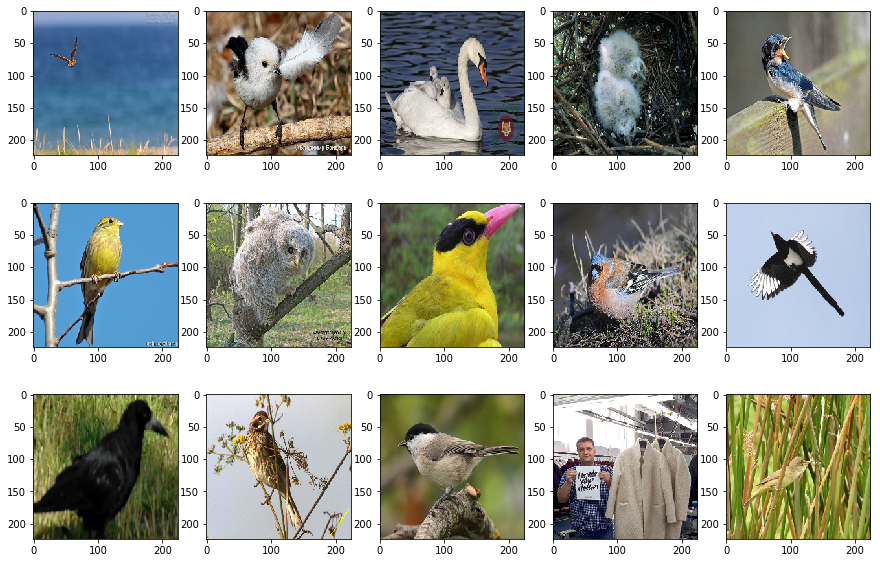

In [11]:
fig = plt.gcf()
fig.set_size_inches(15,10)
for i, img_path in enumerate(random.sample(img_list, 15)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)

    plt.subplot(3, 5, i + 1)
    plt.imshow(img.squeeze())

# Define the network

In [12]:
def get_model(params):
    base_model = MobileNetV2(
        weights="imagenet", include_top=False
    )  # imports the mobilenet model and discards the last 1000 neuron layer.

    for layer in base_model.layers:
        layer.trainable = params["fine_tuning"]
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #x = Dense(1024, activation=params["activation"],kernel_initializer=params["initializer"])(x)  
    #x = Dropout(0.2, name='dropout1')(x)
    # we add dense layers so that the model can learn more complex functions and classify for better results.
    #x = Dense(1024, activation=params["activation"],kernel_initializer=params["initializer"])(x)
    #x = Dropout(0.3, name='dropout2')(x)# dense layer 2
    x = Dense(512, activation=params["activation"],kernel_initializer=params["initializer"])(x)  # dense layer 3
    x = Dropout(params["dropout"], name='dropout3')(x)
    preds = Dense(params["num_classes"],activation='softmax',kernel_initializer="glorot_uniform")(
        x
    )  # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)


    return model

def fine_tune_model(model, params):
    
    for layer in model.layers:
        layer.trainable = params["fine_tuning"]
    
    # or if we want to set the first 20 layers of the network to be non-trainable
    for layer in model.layers[:params["fine_tune_at"]]:
        layer.trainable = False
    for layer in model.layers[params["fine_tune_at"]:]:
        layer.trainable = True
    
    return model

model = get_model(params)

Instructions for updating:
Colocations handled automatically by placer.


/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0 / 255,
    #rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode="nearest"
)  # included in our dependencies

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="categorical",
    shuffle=True,
)

validation_generator = valid_datagen.flow_from_directory(
    DATA_DIR + "/valid",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="categorical",
    shuffle=True,
)

Found 9395 images belonging to 2 classes.
Found 2293 images belonging to 2 classes.


In [15]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
labels

{0: 'bird', 1: 'non-bird'}

In [16]:
adam = keras.optimizers.Adam(lr=params["base_lr"])


model.compile(
    optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"]
)

experiment = Experiment(project_name="bird-vs-not-bird",api_key=COMET_ML)

# log parameters in Comet.ml
experiment.log_parameters(params)

COMET INFO: old comet version (1.0.51) detected. current: 1.0.52 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gaiar/bird-vs-not-bird/12828694aaee48ffa3ae0272d7c34386



# Setup callbacks 

In [21]:
log = callbacks.CSVLogger(os.path.join(MODELS_DIR, "bird-vs-not-bird-log.csv"))

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "bird-vs-not-bird-weights-{epoch:02d}.h5"),
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

lr_decay = callbacks.LearningRateScheduler(
    schedule=lambda epoch: params["base_lr"] * (0.9 ** epoch)
)

early_stopping = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=1, mode="auto"
)

# Train the model

In [18]:
warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [22]:
warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
with experiment.train():
    step_size_train = train_generator.samples // params["batch_size"]
    history = model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // params["batch_size"],
        steps_per_epoch=step_size_train,
        epochs=params["initial_epochs"],
        verbose=1,
        callbacks=[log, checkpoint, lr_decay,early_stopping],
        use_multiprocessing=True,
        workers=7,
        max_queue_size = params["batch_size"] * 3
    )

model.save_weights(os.path.join(MODELS_DIR, "mobilenet.bird-vs-not-bird.generic.h5"))

experiment.end()

Epoch 1/15


Process ForkPoolWorker-168:
Process ForkPoolWorker-167:
Process ForkPoolWorker-163:
Process ForkPoolWorker-155:
Process ForkPoolWorker-158:
Process ForkPoolWorker-162:
Process ForkPoolWorker-165:
Process ForkPoolWorker-161:
Process ForkPoolWorker-156:
Process ForkPoolWorker-159:
Process ForkPoolWorker-157:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-160:
Process ForkPoolWorker-166:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap

  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 235, in _get_batches_of_transformed_samples
    x = self.image_data_generator.standardize(x)
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 226, in _get_batches_of_transformed_samples
    interpolation=se

Epoch 1/15


  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 226, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)
Process ForkPoolWorker-175:
Process ForkPoolWorker-173:
Process ForkPoolWorker-171:
Process ForkPoolWorker-169:
Process ForkPoolWorker-174:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-170:
Process ForkPoolWorker-172:
Traceback (most recent call last):
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gaiar/miniconda3/envs/b

KeyboardInterrupt: 

# Review the results of initial model

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,10)


acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Fine-tuning the model

In [ ]:
params["fine_tuning"] = True


model = fine_tune_model(model, params)

experiment.log_parameters(params)
model.load_weights(os.path.join(MODELS_DIR, "mobilenet.bird-vs-not-bird.generic.h5"))

In [ ]:
adam = keras.optimizers.Adam(lr=params["fine_tune_lr"])

model.compile(
    optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

In [ ]:
total_epochs = params["initial_epochs"] + params["fine_tune_epochs"]



with experiment.train():
    step_size_train = train_generator.samples // params["batch_size"]
    history_fine = model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // params["batch_size"],
        steps_per_epoch=step_size_train,
        initial_epoch = params["initial_epochs"],
        epochs=total_epochs,
        verbose=1,
        callbacks=[log, checkpoint, lr_decay,early_stopping],
        use_multiprocessing=True,
        workers=7,
    )

model.save_weights(os.path.join(MODELS_DIR, "mobilenet.bird-vs-not-bird.fine-tune.h5"))

experiment.end()

# Review the results of fine-tuned model

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([params["fine_tune_epochs"]-1,params["fine_tune_epochs"]-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([params["fine_tune_epochs"]-1,params["fine_tune_epochs"]-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model

In [9]:
BIRDS_DIR = "../../datasets/data"
cwd = os.getcwd()
BIRDS_DIR = os.path.abspath(os.path.join(cwd,BIRDS_DIR))
TEST_DIR = os.path.join(os.path.join(cwd,DATA_DIR),"test/unknown")
print(TEST_DIR)

/home/gaiar/developer/birds-of-berlin/nn/bird-vs-not-bird/dataset/test/unknown


In [10]:
img_list = glob.glob(os.path.join("/home/gaiar/developer/birds-of-berlin/datasets/data/","*/*.jpg"))
print(len(img_list))

61365


In [12]:
for img in img_list:
    os.symlink(img,os.path.join(TEST_DIR,os.path.basename(img)))

In [ ]:
predict_datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    preprocessing_function=preprocess_input
)

PRED_DIR = os.path.join(os.path.join(cwd,DATA_DIR),"test")

pred_generator = predict_datagen.flow_from_directory(
    PRED_DIR,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="categorical",
    shuffle=True,
    follow_links= True
)

In [ ]:
model = get_model(params)
model.load_weights(os.path.join(cwd,MODELS_DIR, "bird-vs-not-bird-weights-05.h5"))

In [ ]:
pred_generator.reset()

# Helps to solve "OSError: broken data stream when reading image file"

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

predictions = model.predict_generator(
        generator=pred_generator,
        verbose=1,
        use_multiprocessing=True,
        workers=7,
        max_queue_size = params["batch_size"] * 3
    )

In [ ]:
predicted_class_indices=np.argmax(predictions,axis=1)

In [ ]:
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in predicted_class_indices]

In [ ]:
#np.clip(predictions,a_min=0,a_max=1)

In [ ]:
#preds = np.concatenate(predictions).ravel()
#len(pred_generator)

In [ ]:
#pred_generator.n / params["batch_size"]

In [ ]:
import pandas as pd
filenames=pred_generator.filenames
results=pd.DataFrame({"filename":filenames,
                      "predictions":preds})

In [ ]:
results.describe()

In [ ]:
non_birds = results[results.predictions == "non-bird"]

In [ ]:
non_birds.describe()

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,10)

In [ ]:
results.Predictions.unique

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,10)
for i, img_path in enumerate(random.sample(list(non_birds["Filename"]), 18)):
    img = image.load_img(os.path.join(PRED_DIR,img_path), target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)

    plt.subplot(6, 5, i + 1)
    plt.imshow(img.squeeze())